In [24]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
import numpy as np
import scipy as sp
import random
import string
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
import sklearn as sk
import sklearn.metrics as skm
import sklearn.cluster as skc
from sklearn.cluster import KMeans
import sklearn.decomposition as skd
import sklearn.mixture as skmix
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go
sns.set(style='white', color_codes=True, font_scale=1.3)

### Dataset Generation: 

In [8]:
# Generate Random Data: 
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, 
                  centers=[(10, 10, 10), (50, 50, 50), (90, 90, 90)], 
                  cluster_std=10, 
                  n_features=3)

df = pd.DataFrame(X, columns=['Environment', 'Social', 'Governance'])
df['Ticker'] = [''.join(random.choices(string.ascii_uppercase, k=4)) for i in range(len(df))]
df.head()

,Environment,Social,Governance,Ticker
0,67.922329,84.301330,87.182823,EIKL
1,41.645136,58.023741,36.950664,OBOR
2,15.324124,10.197528,28.279354,CLJC
3,81.115025,90.606858,98.375286,SZYB
4,78.972074,76.004159,77.477563,HZKZ


In [9]:
def elbow(df, pair): 
    # Elbow method to Determine K 
    X = df 
    K = range(1,11)  # Apply kmeans 1 to 10
    kmeans_models = [KMeans(k).fit(X) for k in K]
    centroids = [m.cluster_centers_ for m in kmeans_models]
    D_k = [spd.cdist(X, cent, 'euclidean') for cent in centroids]
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/X.shape[0] for d in dist]

    # plot elbow curve
    plt.figure(figsize = (7,7))
    plt.plot(K, avgWithinSS, 'b*-')
    plt.xlabel('Number of clusters');
    plt.ylabel('Average within-cluster sum of squares');
    plt.title('Elbow for K-Means clustering');
    plt.suptitle('{}'.format(pair))
    plt.show()

# A helper function to run and plot K-means:     
def kmeans(df, pair, k):
    # Fitting the K-Means model: 
    k_means_model = KMeans(n_clusters=k)
    k_means_model.fit(df)
    centroids = k_means_model.cluster_centers_
    centroids

    # Plot the clusters with their centroids.
    df['cluster_labels_kmeans'] = k_means_model.labels_
    f = sns.lmplot(x=pair[0], y=pair[1], data=df, hue = 'cluster_labels_kmeans', 
                   fit_reg=False, size=5, aspect=1.3)
    f.ax.scatter(centroids[:,0], centroids[:,1], marker='+', s=100,
                 linewidths=2, color='k');
    plt.title('{}'.format(pair), fontsize=15)

### Cluster Identification: 

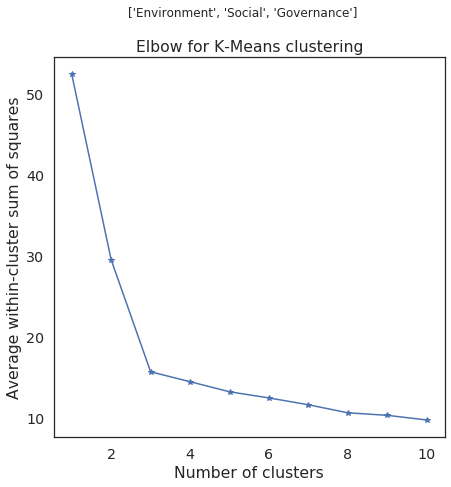

In [10]:
elbow(df[['Environment', 'Social', 'Governance']], ['Environment', 'Social', 'Governance'])

### K-Means Clustering with Interactive Visualization: 

In [ ]:
features = ['Environment', 'Social', 'Governance']

k_means_model = skc.KMeans(n_clusters=3)
k_means_model.fit(df[features])
centroids = k_means_model.cluster_centers_

# Create traces

trace0 = go.Scatter(
    x = df['Environment'],
    y = df['Social'],
    text = df['Ticker'],
    mode = 'markers',
    name = 'markers', 
    marker = dict(
        color = k_means_model.labels_,
        colorscale='Portland',
    )
)

layout = go.Layout( 
    title = 'Environment vs. Social Score',
    hovermode = 'closest',
    xaxis= dict(
        title= 'Environment',
        ticklen= 5,
        zeroline=True,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Social',
        ticklen= 5,
        gridwidth= 2,
    ),

    
)

data = [trace0]

fig= go.Figure(data=data, layout=layout)
fig.update_xaxes(range=[0, 100])
fig.update_yaxes(range=[0, 100])

fig.show()